In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the input data x with b bits.
    
    Parameters:
    x (numpy array): Input data to be quantized, can be negative
    b (int): Number of bits for quantization
    
    Returns:
    numpy array: Quantized data
    """
    x_max = np.max(np.abs(x))
    x_min = -x_max
    R = x_max - x_min
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / (L - 1)

    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [-x_max, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized

def top_lambda_percent(main_vector, dim, lambda_j, b_j):
    """
    Quantize a vector based on a specified percentage of the largest absolute values,
    preserving the signs of the quantized elements.

    Parameters:
    main_vector (numpy array): Input data vector
    dim (int): Dimension of the vector
    lambda_j (float): Percentage of largest absolute values to be quantized
    b_j (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data vector with preserved signs
    """
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Calculate the number of elements to retain based on lambda_j percentage
    num_elements = len(main_vector)
    num_retain = int(np.ceil(lambda_j * num_elements/100 ))

    # Find the indices of the largest `num_retain` absolute values
    indices = np.argsort(-np.abs(main_vector))[:num_retain]

    # Create a temporary vector with the same shape as main_vector
    x_temp_before = np.copy(main_vector)
    
    # Set all elements not in the largest `num_retain` to zero
    x_temp_before[np.setdiff1d(np.arange(num_elements), indices)] = 0

    # Quantize the temporary vector with uniform quantization
    x_q_temp = uniform_quantization(x_temp_before, b_j)

    # Reconstruct the final quantized vector with the signs preserved
    x_q = np.copy(main_vector)
    x_q[indices] = x_q_temp[indices]

    # For elements that are not quantized, we set them to zero (or any other desired value)
    x_q[np.setdiff1d(np.arange(num_elements), indices)] = 0

    err = main_vector - x_q

    # Return the results
    return x_q, err

# Example usage
main_vector = 0.1*np.array([1, -2, 3, -4, 5, 0.1])
dim = len(main_vector)
lambda_j = 0.5  # Percentage of elements to retain
b_j = 3
x_quant, err = top_lambda_percent(main_vector, dim, lambda_j, b_j)
print("Quantized vector:", x_quant)
print("Error:", np.max(np.abs(err)))


Quantized vector: [0.  0.  0.  0.  0.5 0. ]
Error: 0.4


# FL with Quntization and AdaGrad

In [8]:
# Load CIFAR-10 dataset

K = 40



# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
num_clients= K


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
# Load CIFAR-10 dataset


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = list(np.where(y_train == label)[0])  # Convert to list for easy pop operations

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients  # Ensures equal samples per client

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    proportions = np.random.dirichlet(alpha=[0.4] * num_classes)

    # Track the number of samples allocated to this client
    allocated_samples = 0

    while allocated_samples < samples_per_client:
        for label in range(num_classes):
            # Calculate how many samples to take for this class based on proportions
            num_samples = int(proportions[label] * samples_per_client)

            # Adjust to ensure we fill the client's quota exactly
            if allocated_samples + num_samples > samples_per_client:
                num_samples = samples_per_client - allocated_samples

            # Ensure we don't sample more than available for the class
            num_samples = min(num_samples, len(class_indices[label]))

            # Select the samples and add them to the client's data
            class_samples = class_indices[label][:num_samples]
            x_client.extend(x_train[class_samples])
            y_client.extend(y_train[class_samples])

            # Remove used samples from class
            class_indices[label] = class_indices[label][num_samples:]

            # Update allocated sample count
            allocated_samples += len(class_samples)

            # If the client has enough samples, break the loop
            if allocated_samples >= samples_per_client:
                break

    # Shuffle the client's data to randomize order
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))
# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

# client_data now contains non-IID datasets for each client

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------


Client 0: 1250 samples
Label distribution: {0: 22, 1: 328, 3: 249, 4: 64, 5: 7, 6: 147, 8: 194, 9: 239}

Client 1: 1250 samples
Label distribution: {0: 72, 1: 1, 3: 35, 4: 61, 5: 1, 6: 126, 7: 62, 8: 892}

Client 2: 1250 samples
Label distribution: {0: 170, 1: 241, 2: 1, 3: 31, 4: 203, 5: 191, 6: 314, 7: 7, 8: 76, 9: 16}

Client 3: 1250 samples
Label distribution: {0: 82, 1: 98, 2: 52, 3: 3, 4: 492, 5: 389, 7: 17, 8: 6, 9: 111}

Client 4: 1250 samples
Label distribution: {2: 49, 3: 1, 4: 10, 5: 116, 6: 307, 7: 13, 8: 723, 9: 31}

Client 5: 1250 samples
Label distribution: {0: 229, 1: 113, 2: 180, 3: 47, 4: 159, 6: 100, 7: 10, 8: 320, 9: 92}

Client 6: 1250 samples
Label distribution: {1: 222, 2: 207, 3: 14, 4: 3, 5: 15, 6: 500, 8: 64, 9: 225}

Client 7: 1250 samples
Label distribution: {0: 23, 1: 3, 2: 84, 3: 21, 4: 24, 5: 222, 6: 233, 7: 336, 8: 201, 9: 103}

Client 8: 1250 samples
Label distribution: {2: 290, 3: 26, 5: 324, 6: 345, 7: 143, 8: 68, 9: 54}

Client 9: 1250 samples
Label 

In [9]:
num_clients= K
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 4

Lambda = 0.044*np.ones(num_clients) # in the code, it get divided by 100.


# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs





# Federated Averaging algorithm
num_global_iterations = 50
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client
#client_data = []
#samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
 #   x_client = x_train[start:end]
 #   y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

    
    


# Initialize the global model
global_model = create_model()


# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 2.3317 - accuracy: 0.0793
Initial Test Loss: 2.3340
Initial Test Accuracy: 0.0826


Global Iteration 1/50
Client 1/40


C:\Users\afmb\AppData\Local\Temp\ipykernel_9044\506641539.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights)


max: 0.7067253589630127 ----min: -0.7304720282554626
Bits: 813.8415999999999
max error: 0.09724973142147064
max_model: 0.7304720282554626 min_model: -0.7304720282554626
Client 2/40


C:\Users\afmb\AppData\Local\Temp\ipykernel_9044\506641539.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))


max: 0.7865000367164612 ----min: -0.5932045578956604
Bits: 813.8415999999999
max error: 0.10128527134656906
max_model: 0.7865000367164612 min_model: -0.5767666935920716
Client 3/40
max: 0.7033169865608215 ----min: -0.738429605960846
Bits: 813.8415999999999
max error: 0.09100007265806198
max_model: 0.738429605960846 min_model: -0.738429605960846
Client 4/40
max: 0.6387833952903748 ----min: -0.6824842095375061
Bits: 813.8415999999999
max error: 0.10160031914710999
max_model: 0.6824842095375061 min_model: -0.6824842095375061
Client 5/40
max: 0.775174617767334 ----min: -0.6402333378791809
Bits: 813.8415999999999
max error: 0.09130686521530151
max_model: 0.775174617767334 min_model: -0.6718180020650228
Client 6/40
max: 0.5689278244972229 ----min: -0.8084266185760498
Bits: 813.8415999999999
max error: 0.1009054183959961
max_model: 0.59284618695577 min_model: -0.8084266185760498
Client 7/40
max: 0.7059990167617798 ----min: -0.615637481212616
Bits: 813.8415999999999
max error: 0.10884707421064

max: 0.47540390491485596 ----min: -0.5184609889984131
Bits: 813.8415999999999
max error: 0.11151308566331863
max_model: 0.44933285713195814 min_model: -0.5184609889984131
Client 5/40
max: 0.5223527550697327 ----min: -0.578574538230896
Bits: 813.8415999999999
max error: 0.10102827101945877
max_model: 0.5014312664667764 min_model: -0.578574538230896
Client 6/40
max: 0.39294886589050293 ----min: -0.60874342918396
Bits: 813.8415999999999
max error: 0.09849928319454193
max_model: 0.365246057510376 min_model: -0.60874342918396
Client 7/40
max: 0.5475923418998718 ----min: -0.44600266218185425
Bits: 813.8415999999999
max error: 0.10457688570022583
max_model: 0.5475923418998718 min_model: -0.4745800296465556
Client 8/40
max: 0.34107375144958496 ----min: -0.4800020158290863
Bits: 813.8415999999999
max error: 0.0995580330491066
max_model: 0.3520014782746632 min_model: -0.4800020158290863
Client 9/40
max: 0.4384493827819824 ----min: -0.4780918061733246
Bits: 813.8415999999999
max error: 0.10676632

max: 0.33985650539398193 ----min: -0.5049517154693604
Bits: 813.8415999999999
max error: 0.11494405567646027
max_model: 0.370297924677531 min_model: -0.5049517154693604
Client 7/40
max: 0.4449549615383148 ----min: -0.3538612723350525
Bits: 813.8415999999999
max error: 0.10524127632379532
max_model: 0.4449549615383148 min_model: -0.32630030512809755
Client 8/40
max: 0.33502379059791565 ----min: -0.32898038625717163
Bits: 813.8415999999999
max error: 0.10040318965911865
max_model: 0.33502379059791565 min_model: -0.33502379059791565
Client 9/40
max: 0.39332249760627747 ----min: -0.3620811104774475
Bits: 813.8415999999999
max error: 0.11890514194965363
max_model: 0.39332249760627747 min_model: -0.3408794979254405
Client 10/40
max: 0.38858821988105774 ----min: -0.41068321466445923
Bits: 813.8415999999999
max error: 0.10726398229598999
max_model: 0.41068321466445923 min_model: -0.41068321466445923
Client 11/40
max: 0.3231477439403534 ----min: -0.4572758078575134
Bits: 813.8415999999999
max e

Bits: 813.8415999999999
max error: 0.11542895436286926
max_model: 0.32085222005844116 min_model: -0.278071924050649
Client 8/40
max: 0.24780988693237305 ----min: -0.26532992720603943
Bits: 813.8415999999999
max error: 0.1075342521071434
max_model: 0.26532992720603943 min_model: -0.26532992720603943
Client 9/40
max: 0.2821195125579834 ----min: -0.328268826007843
Bits: 813.8415999999999
max error: 0.12548162043094635
max_model: 0.28449964920679727 min_model: -0.328268826007843
Client 10/40
max: 0.40950316190719604 ----min: -0.3339884579181671
Bits: 813.8415999999999
max error: 0.11806024610996246
max_model: 0.40950316190719604 min_model: -0.3549027403195699
Client 11/40
max: 0.3395055830478668 ----min: -0.37561535835266113
Bits: 813.8415999999999
max error: 0.11372480541467667
max_model: 0.3255333105723064 min_model: -0.37561535835266113
Client 12/40
max: 0.33457323908805847 ----min: -0.3724728524684906
Bits: 813.8415999999999
max error: 0.09455232322216034
max_model: 0.3228098054726918 

max: 0.2521558701992035 ----min: -0.2532714009284973
Bits: 813.8415999999999
max error: 0.11986610293388367
max_model: 0.2532714009284973 min_model: -0.2532714009284973
Client 10/40
max: 0.30181100964546204 ----min: -0.29302868247032166
Bits: 813.8415999999999
max error: 0.11339125037193298
max_model: 0.30181100964546204 min_model: -0.30181100964546204
Client 11/40
max: 0.3419080674648285 ----min: -0.31350472569465637
Bits: 813.8415999999999
max error: 0.12059368193149567
max_model: 0.3419080674648285 min_model: -0.29632032513618467
Client 12/40
max: 0.2878801226615906 ----min: -0.2589740753173828
Bits: 813.8415999999999
max error: 0.10981249809265137
max_model: 0.2878801226615906 min_model: -0.24949610630671182
Client 13/40
max: 0.2988121509552002 ----min: -0.3035120368003845
Bits: 813.8415999999999
max error: 0.110591821372509
max_model: 0.3035120368003845 min_model: -0.3035120368003845
Client 14/40
max: 0.2972315549850464 ----min: -0.2637441158294678
Bits: 813.8415999999999
max erro

Bits: 813.8415999999999
max error: 0.11968994140625
max_model: 0.38508254289627075 min_model: -0.33373820384343467
Client 11/40
max: 0.4257076382637024 ----min: -0.2914760708808899
Bits: 813.8415999999999
max error: 0.12527406215667725
max_model: 0.4257076382637024 min_model: -0.31218560139338175
Client 12/40
max: 0.25938746333122253 ----min: -0.26574376225471497
Bits: 813.8415999999999
max error: 0.10456377267837524
max_model: 0.26574376225471497 min_model: -0.26574376225471497
Client 13/40
max: 0.3514736294746399 ----min: -0.2686215043067932
Bits: 813.8415999999999
max error: 0.11840386688709259
max_model: 0.3514736294746399 min_model: -0.25774732828140257
Client 14/40
max: 0.24133282899856567 ----min: -0.2696566581726074
Bits: 813.8415999999999
max error: 0.10296221822500229
max_model: 0.23370243708292637 min_model: -0.2696566581726074
Client 15/40
max: 0.21704891324043274 ----min: -0.2803501784801483
Bits: 813.8415999999999
max error: 0.1019018217921257
max_model: 0.205590130885442

max: 0.26311779022216797 ----min: -0.22724246978759766
Bits: 813.8415999999999
max error: 0.10105132311582565
max_model: 0.26311779022216797 min_model: -0.22803541819254558
Client 13/40
max: 0.2997289001941681 ----min: -0.23984676599502563
Bits: 813.8415999999999
max error: 0.11565110832452774
max_model: 0.2997289001941681 min_model: -0.25976504683494567
Client 14/40
max: 0.21073412895202637 ----min: -0.22999799251556396
Bits: 813.8415999999999
max error: 0.09730067849159241
max_model: 0.19933159351348878 min_model: -0.22999799251556396
Client 15/40
max: 0.2879656255245209 ----min: -0.27794840931892395
Bits: 813.8415999999999
max error: 0.1136149913072586
max_model: 0.2879656255245209 min_model: -0.2879656255245209
Client 16/40
max: 0.36190828680992126 ----min: -0.2035047709941864
Bits: 813.8415999999999
max error: 0.11610910296440125
max_model: 0.36190828680992126 min_model: -0.21714497208595276
Client 17/40
max: 0.25013211369514465 ----min: -0.30971136689186096
Bits: 813.841599999999

Bits: 813.8415999999999
max error: 0.11327977478504181
max_model: 0.24947482347488398 min_model: -0.21621151367823283
Client 14/40
max: 0.27225977182388306 ----min: -0.2351454198360443
Bits: 813.8415999999999
max error: 0.10699716210365295
max_model: 0.27225977182388306 min_model: -0.235958468914032
Client 15/40
max: 0.27104151248931885 ----min: -0.27640029788017273
Bits: 813.8415999999999
max error: 0.11780151724815369
max_model: 0.27640029788017273 min_model: -0.27640029788017273
Client 16/40
max: 0.27285948395729065 ----min: -0.17839810252189636
Bits: 813.8415999999999
max error: 0.1063954085111618
max_model: 0.27285948395729065 min_model: -0.1637156903743744
Client 17/40
max: 0.42089763283729553 ----min: -0.267789751291275
Bits: 813.8415999999999
max error: 0.12822571396827698
max_model: 0.42089763283729553 min_model: -0.2525385797023773
Client 18/40
max: 0.4264613389968872 ----min: -0.22787079215049744
Bits: 813.8415999999999
max error: 0.12064393609762192
max_model: 0.42646133899

max: 0.22971177101135254 ----min: -0.24369356036186218
Bits: 813.8415999999999
max error: 0.11631779372692108
max_model: 0.24369356036186224 min_model: -0.24369356036186218
Client 16/40
max: 0.459670752286911 ----min: -0.24281267821788788
Bits: 813.8415999999999
max error: 0.11754776537418365
max_model: 0.459670752286911 min_model: -0.2145130177338918
Client 17/40
max: 0.3722766041755676 ----min: -0.20961251854896545
Bits: 813.8415999999999
max error: 0.12775535881519318
max_model: 0.3722766041755676 min_model: -0.22336596250534058
Client 18/40
max: 0.2752940356731415 ----min: -0.3207069933414459
Bits: 813.8415999999999
max error: 0.12862879037857056
max_model: 0.2779460608959198 min_model: -0.3207069933414459
Client 19/40
max: 0.21339528262615204 ----min: -0.242536723613739
Bits: 813.8415999999999
max error: 0.10978153347969055
max_model: 0.2101984937985738 min_model: -0.242536723613739
Client 20/40
max: 0.22826701402664185 ----min: -0.22316376864910126
Bits: 813.8415999999999
max err

max: 0.39322879910469055 ----min: -0.1955038607120514
Bits: 813.8415999999999
max error: 0.11336222290992737
max_model: 0.39322879910469055 min_model: -0.18350677291552225
Client 17/40
max: 0.3387452960014343 ----min: -0.3303828239440918
Bits: 813.8415999999999
max error: 0.12665727734565735
max_model: 0.3387452960014343 min_model: -0.3387452960014343
Client 18/40
max: 0.22425225377082825 ----min: -0.22966575622558594
Bits: 813.8415999999999
max error: 0.13101482391357422
max_model: 0.22966575622558594 min_model: -0.22966575622558594
Client 19/40
max: 0.22808581590652466 ----min: -0.24640357494354248
Bits: 813.8415999999999
max error: 0.10697054862976074
max_model: 0.21354976495107014 min_model: -0.24640357494354248
Client 20/40
max: 0.20370079576969147 ----min: -0.20631331205368042
Bits: 813.8415999999999
max error: 0.10907172411680222
max_model: 0.20631331205368042 min_model: -0.20631331205368042
Client 21/40
max: 0.35575151443481445 ----min: -0.2069387435913086
Bits: 813.84159999999

Bits: 813.8415999999999
max error: 0.1298987716436386
max_model: 0.37929266691207886 min_model: -0.3287203113238017
Client 18/40
max: 0.17944076657295227 ----min: -0.18593522906303406
Bits: 813.8415999999999
max error: 0.11849550902843475
max_model: 0.18593522906303406 min_model: -0.18593522906303406
Client 19/40
max: 0.22559162974357605 ----min: -0.20107334852218628
Bits: 813.8415999999999
max error: 0.10484002530574799
max_model: 0.22559162974357605 min_model: -0.1955127457777659
Client 20/40
max: 0.2547507882118225 ----min: -0.2502538561820984
Bits: 813.8415999999999
max error: 0.11795023083686829
max_model: 0.2547507882118225 min_model: -0.2547507882118225
Client 21/40
max: 0.26931726932525635 ----min: -0.19899362325668335
Bits: 813.8415999999999
max error: 0.12265251576900482
max_model: 0.26931726932525635 min_model: -0.19749933083852134
Client 22/40
max: 0.19534355401992798 ----min: -0.20864343643188477
Bits: 813.8415999999999
max error: 0.10323740541934967
max_model: 0.208643436

max: 0.25558245182037354 ----min: -0.21758663654327393
Bits: 813.8415999999999
max error: 0.11081959307193756
max_model: 0.25558245182037354 min_model: -0.22150479157765707
Client 20/40
max: 0.2943379282951355 ----min: -0.2786238193511963
Bits: 813.8415999999999
max error: 0.12083087861537933
max_model: 0.2943379282951355 min_model: -0.2943379282951355
Client 21/40
max: 0.3075670301914215 ----min: -0.20269757509231567
Bits: 813.8415999999999
max error: 0.1258656233549118
max_model: 0.3075670301914215 min_model: -0.18454021811485288
Client 22/40
max: 0.25379645824432373 ----min: -0.25369179248809814
Bits: 813.8415999999999
max error: 0.11900094896554947
max_model: 0.25379645824432373 min_model: -0.25379645824432373
Client 23/40
max: 0.17374250292778015 ----min: -0.19374190270900726
Bits: 813.8415999999999
max error: 0.10371360182762146
max_model: 0.16790964901447297 min_model: -0.19374190270900726
Client 24/40
max: 0.21166571974754333 ----min: -0.18807333707809448
Bits: 813.841599999999

Bits: 813.8415999999999
max error: 0.11348610371351242
max_model: 0.31924670934677124 min_model: -0.2766804814338684
Client 21/40
max: 0.22698959708213806 ----min: -0.19783782958984375
Bits: 813.8415999999999
max error: 0.13129539787769318
max_model: 0.22698959708213806 min_model: -0.19672431747118632
Client 22/40
max: 0.19003739953041077 ----min: -0.1944427490234375
Bits: 813.8415999999999
max error: 0.10178157687187195
max_model: 0.1944427490234375 min_model: -0.1944427490234375
Client 23/40
max: 0.19541102647781372 ----min: -0.20712250471115112
Bits: 813.8415999999999
max error: 0.10987885296344757
max_model: 0.20712250471115112 min_model: -0.20712250471115112
Client 24/40
max: 0.30215394496917725 ----min: -0.2354261726140976
Bits: 813.8415999999999
max error: 0.12696455419063568
max_model: 0.30215394496917725 min_model: -0.2215795596440633
Client 25/40
max: 0.2805864214897156 ----min: -0.2102670967578888
Bits: 813.8415999999999
max error: 0.10809419304132462
max_model: 0.2805864214

max: 0.2288956642150879 ----min: -0.19149523973464966
Bits: 813.8415999999999
max error: 0.10994503647089005
max_model: 0.2288956642150879 min_model: -0.19837624231974282
Client 23/40
max: 0.21342366933822632 ----min: -0.1957305669784546
Bits: 813.8415999999999
max error: 0.10439404845237732
max_model: 0.21342366933822632 min_model: -0.18496718009312949
Client 24/40
max: 0.20918220281600952 ----min: -0.22139951586723328
Bits: 813.8415999999999
max error: 0.12474405765533447
max_model: 0.22139951586723328 min_model: -0.22139951586723328
Client 25/40
max: 0.29801279306411743 ----min: -0.16901804506778717
Bits: 813.8415999999999
max error: 0.09691503643989563
max_model: 0.29801279306411743 min_model: -0.17880767583847046
Client 26/40
max: 0.2200319766998291 ----min: -0.22211965918540955
Bits: 813.8415999999999
max error: 0.12078874558210373
max_model: 0.22211965918540955 min_model: -0.22211965918540955
Client 27/40
max: 0.31184113025665283 ----min: -0.20148694515228271
Bits: 813.841599999

Bits: 813.8415999999999
max error: 0.10562752932310104
max_model: 0.18011531035105394 min_model: -0.2456117868423462
Client 24/40
max: 0.28675854206085205 ----min: -0.23844337463378906
Bits: 813.8415999999999
max error: 0.11786994338035583
max_model: 0.28675854206085205 min_model: -0.24852406978607178
Client 25/40
max: 0.2747916281223297 ----min: -0.1761608123779297
Bits: 813.8415999999999
max error: 0.09768310189247131
max_model: 0.2747916281223297 min_model: -0.16487497687339783
Client 26/40
max: 0.45670509338378906 ----min: -0.30565351247787476
Bits: 813.8415999999999
max error: 0.12567681074142456
max_model: 0.45670509338378906 min_model: -0.3349170684814453
Client 27/40
max: 0.26010459661483765 ----min: -0.20866715908050537
Bits: 813.8415999999999
max error: 0.11563696712255478
max_model: 0.26010459661483765 min_model: -0.2254239837328593
Client 28/40
max: 0.19579154253005981 ----min: -0.19509071111679077
Bits: 813.8415999999999
max error: 0.09546595811843872
max_model: 0.19579154

max: 0.2128308117389679 ----min: -0.16564470529556274
Bits: 813.8415999999999
max error: 0.10272184014320374
max_model: 0.2128308117389679 min_model: -0.15607592860857644
Client 26/40
max: 0.26584047079086304 ----min: -0.20601370930671692
Bits: 813.8415999999999
max error: 0.11553281545639038
max_model: 0.26584047079086304 min_model: -0.19494967857996623
Client 27/40
max: 0.2846963405609131 ----min: -0.26612988114356995
Bits: 813.8415999999999
max error: 0.11400651186704636
max_model: 0.2846963405609131 min_model: -0.2846963405609131
Client 28/40
max: 0.19789060950279236 ----min: -0.1862313449382782
Bits: 813.8415999999999
max error: 0.08924710005521774
max_model: 0.19789060950279236 min_model: -0.19789060950279236
Client 29/40
max: 0.1783899962902069 ----min: -0.24854248762130737
Bits: 813.8415999999999
max error: 0.12354384362697601
max_model: 0.18226449092229202 min_model: -0.24854248762130737
Client 30/40
max: 0.3813515603542328 ----min: -0.25901153683662415
Bits: 813.8415999999999

Bits: 813.8415999999999
max error: 0.129542738199234
max_model: 0.3544030487537384 min_model: -0.2598955690860748
Client 27/40
max: 0.4454885721206665 ----min: -0.244291290640831
Bits: 813.8415999999999
max error: 0.11478518694639206
max_model: 0.4454885721206665 min_model: -0.2672931432723999
Client 28/40
max: 0.21678785979747772 ----min: -0.22003889083862305
Bits: 813.8415999999999
max error: 0.09942223131656647
max_model: 0.22003889083862305 min_model: -0.22003889083862305
Client 29/40
max: 0.2871113419532776 ----min: -0.212672621011734
Bits: 813.8415999999999
max error: 0.12455414235591888
max_model: 0.2871113419532776 min_model: -0.21054831743240357
Client 30/40
max: 0.35447508096694946 ----min: -0.2217269092798233
Bits: 813.8415999999999
max error: 0.1251448392868042
max_model: 0.35447508096694946 min_model: -0.21268504858016968
Client 31/40
max: 0.3241334557533264 ----min: -0.27485623955726624
Bits: 813.8415999999999
max error: 0.13014096021652222
max_model: 0.3241334557533264 m

max: 0.18695273995399475 ----min: -0.18371516466140747
Bits: 813.8415999999999
max error: 0.0945938304066658
max_model: 0.18695273995399475 min_model: -0.18695273995399475
Client 29/40
max: 0.18133080005645752 ----min: -0.22364473342895508
Bits: 813.8415999999999
max error: 0.11981305480003357
max_model: 0.19382543563842775 min_model: -0.22364473342895508
Client 30/40
max: 0.41212138533592224 ----min: -0.20904627442359924
Bits: 813.8415999999999
max error: 0.12253846228122711
max_model: 0.41212138533592224 min_model: -0.1923233131567637
Client 31/40
max: 0.29582637548446655 ----min: -0.24979084730148315
Bits: 813.8415999999999
max error: 0.13697382807731628
max_model: 0.29582637548446655 min_model: -0.2563828587532043
Client 32/40
max: 0.49961018562316895 ----min: -0.3391006588935852
Bits: 813.8415999999999
max error: 0.1401432454586029
max_model: 0.49961018562316895 min_model: -0.3663808027903239
Client 33/40
max: 0.23964008688926697 ----min: -0.16780537366867065
Bits: 813.84159999999

max: 0.2713378667831421 ----min: -0.2366952896118164
Bits: 813.8415999999999
max error: 0.1254761815071106
max_model: 0.2713378667831421 min_model: -0.23515948454538982
Client 31/40
max: 0.25755709409713745 ----min: -0.23495392501354218
Bits: 813.8415999999999
max error: 0.11769332736730576
max_model: 0.25755709409713745 min_model: -0.22321614821751912
Client 32/40
max: 0.4257422685623169 ----min: -0.21788762509822845
Bits: 813.8415999999999
max error: 0.12266123294830322
max_model: 0.4257422685623169 min_model: -0.1986797253290812
Client 33/40
max: 0.2038017213344574 ----min: -0.18034550547599792
Bits: 813.8415999999999
max error: 0.11424192786216736
max_model: 0.2038017213344574 min_model: -0.17662815848986307
Client 34/40
max: 0.2686576247215271 ----min: -0.17898520827293396
Bits: 813.8415999999999
max error: 0.11454978585243225
max_model: 0.2686576247215271 min_model: -0.16119457483291627
Client 35/40
max: 0.31617769598960876 ----min: -0.19703809916973114
Bits: 813.8415999999999
ma

max: 0.32119637727737427 ----min: -0.19231945276260376
Bits: 813.8415999999999
max error: 0.12334132194519043
max_model: 0.32119637727737427 min_model: -0.19271782636642457
Client 33/40
max: 0.20685037970542908 ----min: -0.1753150373697281
Bits: 813.8415999999999
max error: 0.10878004133701324
max_model: 0.20685037970542908 min_model: -0.17927032907803853
Client 34/40
max: 0.26612383127212524 ----min: -0.20725619792938232
Bits: 813.8415999999999
max error: 0.11952532082796097
max_model: 0.26612383127212524 min_model: -0.19515747626622518
Client 35/40
max: 0.19128787517547607 ----min: -0.15905171632766724
Bits: 813.8415999999999
max error: 0.09005973488092422
max_model: 0.19128787517547607 min_model: -0.16578282515207926
Client 36/40
max: 0.4073345363140106 ----min: -0.2667202651500702
Bits: 813.8415999999999
max error: 0.125623419880867
max_model: 0.4073345363140106 min_model: -0.24440072178840638
Client 37/40
max: 0.24741670489311218 ----min: -0.17617931962013245
Bits: 813.84159999999

Bits: 813.8415999999999
max error: 0.11630082130432129
max_model: 0.2882964611053467 min_model: -0.21141740481058757
Client 34/40
max: 0.22177278995513916 ----min: -0.2093382179737091
Bits: 813.8415999999999
max error: 0.11611577123403549
max_model: 0.22177278995513916 min_model: -0.22177278995513916
Client 35/40
max: 0.28366202116012573 ----min: -0.21110838651657104
Bits: 813.8415999999999
max error: 0.11575940251350403
max_model: 0.28366202116012573 min_model: -0.20801881551742554
Client 36/40
max: 0.44070178270339966 ----min: -0.21566689014434814
Bits: 813.8415999999999
max error: 0.1270122081041336
max_model: 0.44070178270339966 min_model: -0.20566083192825318
Client 37/40
max: 0.2646060585975647 ----min: -0.19565579295158386
Bits: 813.8415999999999
max error: 0.11473945528268814
max_model: 0.2646060585975647 min_model: -0.19404444297154744
Client 38/40
max: 0.24641427397727966 ----min: -0.24700266122817993
Bits: 813.8415999999999
max error: 0.10923746228218079
max_model: 0.2470026

Bits: 813.8415999999999
max error: 0.11962616443634033
max_model: 0.4403612017631531 min_model: -0.26421672105789185
Client 35/40
max: 0.36604171991348267 ----min: -0.27543726563453674
Bits: 813.8415999999999
max error: 0.10556459426879883
max_model: 0.36604171991348267 min_model: -0.2684305946032206
Client 36/40
max: 0.43181052803993225 ----min: -0.2300652414560318
Bits: 813.8415999999999
max error: 0.12132188677787781
max_model: 0.43181052803993225 min_model: -0.20151157975196837
Client 37/40
max: 0.33890289068222046 ----min: -0.19479162991046906
Bits: 813.8415999999999
max error: 0.1174728274345398
max_model: 0.33890289068222046 min_model: -0.2033417344093323
Client 38/40
max: 0.17472021281719208 ----min: -0.18197080492973328
Bits: 813.8415999999999
max error: 0.10144998133182526
max_model: 0.18197080492973328 min_model: -0.18197080492973328
Client 39/40
max: 0.2621641755104065 ----min: -0.2112300843000412
Bits: 813.8415999999999
max error: 0.1123238056898117
max_model: 0.2621641755

max: 0.4694756269454956 ----min: -0.2379172444343567
Bits: 813.8415999999999
max error: 0.12152662873268127
max_model: 0.4694756269454956 min_model: -0.21908862590789796
Client 37/40
max: 0.45162147283554077 ----min: -0.23686671257019043
Bits: 813.8415999999999
max error: 0.12772943079471588
max_model: 0.45162147283554077 min_model: -0.21075668732325237
Client 38/40
max: 0.1981138437986374 ----min: -0.263957142829895
Bits: 813.8415999999999
max error: 0.10552042722702026
max_model: 0.19356857140858963 min_model: -0.263957142829895
Client 39/40
max: 0.27442407608032227 ----min: -0.256134957075119
Bits: 813.8415999999999
max error: 0.11440326273441315
max_model: 0.27442407608032227 min_model: -0.27442407608032227
Client 40/40
max: 0.3762502074241638 ----min: -0.22614741325378418
Bits: 813.8415999999999
max error: 0.10147128999233246
max_model: 0.3762502074241638 min_model: -0.2257501244544983
------------------------------------------------------------------------------------------------

Bits: 813.8415999999999
max error: 0.11455491930246353
max_model: 0.31959807872772217 min_model: -0.23437192440032958
Client 38/40
max: 0.2278563380241394 ----min: -0.19510015845298767
Bits: 813.8415999999999
max error: 0.10652664303779602
max_model: 0.2278563380241394 min_model: -0.19747549295425415
Client 39/40
max: 0.48045167326927185 ----min: -0.214175283908844
Bits: 813.8415999999999
max error: 0.11909561604261398
max_model: 0.48045167326927185 min_model: -0.22421078085899354
Client 40/40
max: 0.23530517518520355 ----min: -0.18936124444007874
Bits: 813.8415999999999
max error: 0.09609699249267578
max_model: 0.2353051751852036 min_model: -0.20393115182717642
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.9137 - accuracy: 0.3210
Global Test loss: 1.9137, Global Test accuracy: 0.3210
------------------------------ ------FedAvg Benchmark-----------------------------

max: 0.33845824003219604 ----min: -0.222599059343338
Bits: 813.8415999999999
max error: 0.12076610326766968
max_model: 0.33845824003219604 min_model: -0.2030749440193176
Client 40/40
max: 0.2662997841835022 ----min: -0.16241000592708588
Bits: 813.8415999999999
max error: 0.08919897675514221
max_model: 0.2662997841835022 min_model: -0.1597798705101013
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.9086 - accuracy: 0.3289
Global Test loss: 1.9086, Global Test accuracy: 0.3289
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.7364 - accuracy: 0.4937
_FedAvg Global Test loss: 1.7364, _FedAvg Global Test accuracy: 0.4937
------------------------------------------------------------------------------------------------------
Global Iteration 26/50
Client 1/40


Bits: 813.8415999999999
max error: 0.09593294560909271
max_model: 0.30833351612091064 min_model: -0.18500010967254638
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.8893 - accuracy: 0.3362
Global Test loss: 1.8893, Global Test accuracy: 0.3362
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.7574 - accuracy: 0.4989
_FedAvg Global Test loss: 1.7574, _FedAvg Global Test accuracy: 0.4989
------------------------------------------------------------------------------------------------------
Global Iteration 27/50
Client 1/40
max: 0.2630278468132019 ----min: -0.2476220577955246
Bits: 813.8415999999999
max error: 0.12490841746330261
max_model: 0.2630278468132019 min_model: -0.2630278468132019
Client 2/40
max: 0.22407284379005432 ----min: -0.19789494574069977

313/313 [==============================] - 3s 9ms/step - loss: 1.8812 - accuracy: 0.3403
Global Test loss: 1.8812, Global Test accuracy: 0.3403
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.7751 - accuracy: 0.4962
_FedAvg Global Test loss: 1.7751, _FedAvg Global Test accuracy: 0.4962
------------------------------------------------------------------------------------------------------
Global Iteration 28/50
Client 1/40
max: 0.3483940362930298 ----min: -0.21601399779319763
Bits: 813.8415999999999
max error: 0.13172979652881622
max_model: 0.3483940362930298 min_model: -0.20903642177581785
Client 2/40
max: 0.1923292875289917 ----min: -0.1977667212486267
Bits: 813.8415999999999
max error: 0.09371226280927658
max_model: 0.1977667212486267 min_model: -0.1977667212486267
Client 3/40
max: 0.38810303807258606 ----min: -0.3670642673969269
Bits: 813.8415999999999
max error: 0.1

313/313 [==============================] - 3s 8ms/step - loss: 1.7773 - accuracy: 0.4945
_FedAvg Global Test loss: 1.7773, _FedAvg Global Test accuracy: 0.4945
------------------------------------------------------------------------------------------------------
Global Iteration 29/50
Client 1/40
max: 0.2402905374765396 ----min: -0.26116153597831726
Bits: 813.8415999999999
max error: 0.12750792503356934
max_model: 0.22633999784787495 min_model: -0.26116153597831726
Client 2/40
max: 0.18826094269752502 ----min: -0.18311993777751923
Bits: 813.8415999999999
max error: 0.10101386159658432
max_model: 0.18826094269752502 min_model: -0.18826094269752502
Client 3/40
max: 0.3015934228897095 ----min: -0.2487851083278656
Bits: 813.8415999999999
max error: 0.12985561788082123
max_model: 0.3015934228897095 min_model: -0.2613809665044149
Client 4/40
max: 0.24103069305419922 ----min: -0.21925723552703857
Bits: 813.8415999999999
max error: 0.11896038800477982
max_model: 0.24103069305419922 min_model: 

max: 0.3136852979660034 ----min: -0.24686414003372192
Bits: 813.8415999999999
max error: 0.13675682246685028
max_model: 0.3136852979660034 min_model: -0.23003588517506918
Client 2/40
max: 0.22428539395332336 ----min: -0.18794527649879456
Bits: 813.8415999999999
max error: 0.10297361761331558
max_model: 0.22428539395332336 min_model: -0.1943806747595469
Client 3/40
max: 0.28645583987236023 ----min: -0.2134658843278885
Bits: 813.8415999999999
max error: 0.12938641011714935
max_model: 0.28645583987236023 min_model: -0.2100676159063975
Client 4/40
max: 0.19834710657596588 ----min: -0.19611778855323792
Bits: 813.8415999999999
max error: 0.11410591006278992
max_model: 0.19834710657596588 min_model: -0.19834710657596588
Client 5/40
max: 0.24626176059246063 ----min: -0.2084396481513977
Bits: 813.8415999999999
max error: 0.09931456297636032
max_model: 0.24626176059246058 min_model: -0.21342685918013254
Client 6/40
max: 0.364997923374176 ----min: -0.23523491621017456
Bits: 813.8415999999999
max 

max: 0.30728667974472046 ----min: -0.27689093351364136
Bits: 813.8415999999999
max error: 0.1030271053314209
max_model: 0.30728667974472046 min_model: -0.2663151224454244
Client 3/40
max: 0.25833380222320557 ----min: -0.21583645045757294
Bits: 813.8415999999999
max error: 0.12740331888198853
max_model: 0.25833380222320557 min_model: -0.22388929526011148
Client 4/40
max: 0.20083749294281006 ----min: -0.20823267102241516
Bits: 813.8415999999999
max error: 0.11545093357563019
max_model: 0.20823267102241516 min_model: -0.20823267102241516
Client 5/40
max: 0.24407455325126648 ----min: -0.19617486000061035
Bits: 813.8415999999999
max error: 0.10368447750806808
max_model: 0.24407455325126648 min_model: -0.21153127948443096
Client 6/40
max: 0.26304396986961365 ----min: -0.24280789494514465
Bits: 813.8415999999999
max error: 0.13037994503974915
max_model: 0.26304396986961365 min_model: -0.22797144055366517
Client 7/40
max: 0.1933031976222992 ----min: -0.21566714346408844
Bits: 813.8415999999999

Bits: 813.8415999999999
max error: 0.12910091876983643
max_model: 0.4735534191131592 min_model: -0.22099159558614095
Client 4/40
max: 0.23040693998336792 ----min: -0.2051239162683487
Bits: 813.8415999999999
max error: 0.11750553548336029
max_model: 0.23040693998336792 min_model: -0.1996860146522522
Client 5/40
max: 0.19663643836975098 ----min: -0.20321965217590332
Bits: 813.8415999999999
max error: 0.11011204868555069
max_model: 0.20321965217590332 min_model: -0.20321965217590332
Client 6/40
max: 0.2214307188987732 ----min: -0.21954217553138733
Bits: 813.8415999999999
max error: 0.13514213263988495
max_model: 0.2214307188987732 min_model: -0.2214307188987732
Client 7/40
max: 0.22829079627990723 ----min: -0.17592936754226685
Bits: 813.8415999999999
max error: 0.1148034930229187
max_model: 0.22829079627990723 min_model: -0.1674132506052653
Client 8/40
max: 0.27478575706481934 ----min: -0.25126445293426514
Bits: 813.8415999999999
max error: 0.13980869948863983
max_model: 0.274785757064819

max: 0.26209697127342224 ----min: -0.23362161219120026
Bits: 813.8415999999999
max error: 0.12369199097156525
max_model: 0.26209697127342224 min_model: -0.22715070843696594
Client 6/40
max: 0.3013859689235687 ----min: -0.24218671023845673
Bits: 813.8415999999999
max error: 0.13448752462863922
max_model: 0.3013859689235687 min_model: -0.2612011730670929
Client 7/40
max: 0.22824251651763916 ----min: -0.20605069398880005
Bits: 813.8415999999999
max error: 0.11977612227201462
max_model: 0.22824251651763916 min_model: -0.19781018098195394
Client 8/40
max: 0.3522587716579437 ----min: -0.23912513256072998
Bits: 813.8415999999999
max error: 0.13201665878295898
max_model: 0.3522587716579437 min_model: -0.2583230992158254
Client 9/40
max: 0.2593243420124054 ----min: -0.23304292559623718
Bits: 813.8415999999999
max error: 0.13673724234104156
max_model: 0.2593243420124054 min_model: -0.224747763077418
Client 10/40
max: 0.21947968006134033 ----min: -0.24269938468933105
Bits: 813.8415999999999
max e

Bits: 813.8415999999999
max error: 0.1315486878156662
max_model: 0.31212639808654785 min_model: -0.2288926919301351
Client 7/40
max: 0.2817128598690033 ----min: -0.22309359908103943
Bits: 813.8415999999999
max error: 0.12218274921178818
max_model: 0.2817128598690033 min_model: -0.20658943057060242
Client 8/40
max: 0.2194634974002838 ----min: -0.19614385068416595
Bits: 813.8415999999999
max error: 0.13144461810588837
max_model: 0.2194634974002838 min_model: -0.19020169774691265
Client 9/40
max: 0.3114362955093384 ----min: -0.21714451909065247
Bits: 813.8415999999999
max error: 0.1259567141532898
max_model: 0.3114362955093384 min_model: -0.22838661670684815
Client 10/40
max: 0.20338842272758484 ----min: -0.21716637909412384
Bits: 813.8415999999999
max error: 0.12381390482187271
max_model: 0.21716637909412384 min_model: -0.21716637909412384
Client 11/40
max: 0.19537271559238434 ----min: -0.2077895998954773
Bits: 813.8415999999999
max error: 0.12335925549268723
max_model: 0.207789599895477

max: 0.4292222261428833 ----min: -0.22221870720386505
Bits: 813.8415999999999
max error: 0.13516704738140106
max_model: 0.4292222261428833 min_model: -0.20030370553334553
Client 9/40
max: 0.25390514731407166 ----min: -0.22316116094589233
Bits: 813.8415999999999
max error: 0.13123740255832672
max_model: 0.25390514731407166 min_model: -0.22005112767219542
Client 10/40
max: 0.22273710370063782 ----min: -0.20725008845329285
Bits: 813.8415999999999
max error: 0.12805205583572388
max_model: 0.22273710370063782 min_model: -0.19303882320721943
Client 11/40
max: 0.3100360035896301 ----min: -0.23228392004966736
Bits: 813.8415999999999
max error: 0.13646982610225677
max_model: 0.3100360035896301 min_model: -0.22735973596572875
Client 12/40
max: 0.22341084480285645 ----min: -0.16707465052604675
Bits: 813.8415999999999
max error: 0.11074154078960419
max_model: 0.22341084480285645 min_model: -0.16383461952209472
Client 13/40
max: 0.405293345451355 ----min: -0.30299749970436096
Bits: 813.841599999999

max: 0.22596211731433868 ----min: -0.24222815036773682
Bits: 813.8415999999999
max error: 0.13385450839996338
max_model: 0.2099310636520385 min_model: -0.24222815036773682
Client 10/40
max: 0.23937863111495972 ----min: -0.23765887320041656
Bits: 813.8415999999999
max error: 0.1276666224002838
max_model: 0.23937863111495972 min_model: -0.23937863111495972
Client 11/40
max: 0.20547346770763397 ----min: -0.20919546484947205
Bits: 813.8415999999999
max error: 0.11084175109863281
max_model: 0.20919546484947205 min_model: -0.20919546484947205
Client 12/40
max: 0.23740053176879883 ----min: -0.18117548525333405
Bits: 813.8415999999999
max error: 0.10856643319129944
max_model: 0.23740053176879883 min_model: -0.17409372329711914
Client 13/40
max: 0.32132771611213684 ----min: -0.4234410226345062
Bits: 813.8415999999999
max error: 0.15605272352695465
max_model: 0.3105234165986379 min_model: -0.4234410226345062
Client 14/40
max: 0.24705371260643005 ----min: -0.20066821575164795
Bits: 813.8415999999

Bits: 813.8415999999999
max error: 0.13199016451835632
max_model: 0.18466723362604776 min_model: -0.2518189549446106
Client 11/40
max: 0.2614626884460449 ----min: -0.18756990134716034
Bits: 813.8415999999999
max error: 0.12428762018680573
max_model: 0.2614626884460449 min_model: -0.19173930486043295
Client 12/40
max: 0.24993622303009033 ----min: -0.18542629480361938
Bits: 813.8415999999999
max error: 0.10658671706914902
max_model: 0.24993622303009033 min_model: -0.18328656355539957
Client 13/40
max: 0.4151868522167206 ----min: -0.28042861819267273
Bits: 813.8415999999999
max error: 0.1252014935016632
max_model: 0.4151868522167206 min_model: -0.30447035829226177
Client 14/40
max: 0.1938173621892929 ----min: -0.2299596667289734
Bits: 813.8415999999999
max error: 0.1175767108798027
max_model: 0.19929837783177695 min_model: -0.2299596667289734
Client 15/40
max: 0.19781117141246796 ----min: -0.2077348530292511
Bits: 813.8415999999999
max error: 0.11939632892608643
max_model: 0.2077348530292

max error: 0.14931684732437134
max_model: 0.4104918837547302 min_model: -0.3557596325874329
Client 12/40
max: 0.20210382342338562 ----min: -0.2203845977783203
Bits: 813.8415999999999
max error: 0.10755575448274612
max_model: 0.19099998474121094 min_model: -0.2203845977783203
Client 13/40
max: 0.23424530029296875 ----min: -0.23575927317142487
Bits: 813.8415999999999
max error: 0.1154056191444397
max_model: 0.23575927317142487 min_model: -0.23575927317142487
Client 14/40
max: 0.2489151656627655 ----min: -0.19728456437587738
Bits: 813.8415999999999
max error: 0.11756335198879242
max_model: 0.24891516566276556 min_model: -0.1825377881526947
Client 15/40
max: 0.30043816566467285 ----min: -0.23702111840248108
Bits: 813.8415999999999
max error: 0.1246044784784317
max_model: 0.30043816566467285 min_model: -0.22032132148742675
Client 16/40
max: 0.22996467351913452 ----min: -0.21622131764888763
Bits: 813.8415999999999
max error: 0.11983872205018997
max_model: 0.22996467351913452 min_model: -0.22

max: 0.3401038944721222 ----min: -0.271485298871994
Bits: 813.8415999999999
max error: 0.12933605909347534
max_model: 0.3401038944721222 min_model: -0.24940952261288962
Client 14/40
max: 0.20659573376178741 ----min: -0.21686387062072754
Bits: 813.8415999999999
max error: 0.12168584764003754
max_model: 0.21686387062072754 min_model: -0.21686387062072754
Client 15/40
max: 0.25311100482940674 ----min: -0.21322405338287354
Bits: 813.8415999999999
max error: 0.12617310881614685
max_model: 0.25311100482940674 min_model: -0.2193628708521525
Client 16/40
max: 0.20900435745716095 ----min: -0.15845531225204468
Bits: 813.8415999999999
max error: 0.10298626124858856
max_model: 0.20900435745716095 min_model: -0.15326986213525137
Client 17/40
max: 0.2445881962776184 ----min: -0.22254067659378052
Bits: 813.8415999999999
max error: 0.14068752527236938
max_model: 0.2445881962776184 min_model: -0.21197643677393596
Client 18/40
max: 0.21178215742111206 ----min: -0.18525461852550507
Bits: 813.841599999999

max: 0.3340036869049072 ----min: -0.25225651264190674
Bits: 813.8415999999999
max error: 0.12990513443946838
max_model: 0.3340036869049072 min_model: -0.24493603706359862
Client 15/40
max: 0.2264530062675476 ----min: -0.19750094413757324
Bits: 813.8415999999999
max error: 0.11999198794364929
max_model: 0.2264530062675476 min_model: -0.19625927209854127
Client 16/40
max: 0.23705309629440308 ----min: -0.2209853231906891
Bits: 813.8415999999999
max error: 0.1209241971373558
max_model: 0.23705309629440313 min_model: -0.20544601678848268
Client 17/40
max: 0.3541502058506012 ----min: -0.20885223150253296
Bits: 813.8415999999999
max error: 0.13161948323249817
max_model: 0.3541502058506012 min_model: -0.21249012351036073
Client 18/40
max: 0.2243110090494156 ----min: -0.23918288946151733
Bits: 813.8415999999999
max error: 0.12983417510986328
max_model: 0.23918288946151733 min_model: -0.23918288946151733
Client 19/40
max: 0.20984987914562225 ----min: -0.22090567648410797
Bits: 813.8415999999999


Bits: 813.8415999999999
max error: 0.1255597025156021
max_model: 0.23142922918001813 min_model: -0.26703372597694397
Client 16/40
max: 0.232380211353302 ----min: -0.1958533525466919
Bits: 813.8415999999999
max error: 0.11178481578826904
max_model: 0.232380211353302 min_model: -0.20139618317286173
Client 17/40
max: 0.3938245177268982 ----min: -0.2490699291229248
Bits: 813.8415999999999
max error: 0.13016772270202637
max_model: 0.3938245177268982 min_model: -0.2362947106361389
Client 18/40
max: 0.20604903995990753 ----min: -0.21597424149513245
Bits: 813.8415999999999
max error: 0.1317080855369568
max_model: 0.21597424149513245 min_model: -0.21597424149513245
Client 19/40
max: 0.18580694496631622 ----min: -0.19424453377723694
Bits: 813.8415999999999
max error: 0.10891446471214294
max_model: 0.19424453377723694 min_model: -0.19424453377723694
Client 20/40
max: 0.19940048456192017 ----min: -0.2149927318096161
Bits: 813.8415999999999
max error: 0.11799836158752441
max_model: 0.18632703423500

max: 0.2351066768169403 ----min: -0.26632848381996155
Bits: 813.8415999999999
max error: 0.1309754103422165
max_model: 0.23081801931063328 min_model: -0.26632848381996155
Client 18/40
max: 0.3878026008605957 ----min: -0.4032774567604065
Bits: 813.8415999999999
max error: 0.13635730743408203
max_model: 0.4032774567604065 min_model: -0.4032774567604065
Client 19/40
max: 0.2666253447532654 ----min: -0.19948306679725647
Bits: 813.8415999999999
max error: 0.11244797706604004
max_model: 0.2666253447532654 min_model: -0.19552525281906127
Client 20/40
max: 0.26507192850112915 ----min: -0.2314363420009613
Bits: 813.8415999999999
max error: 0.12022550404071808
max_model: 0.26507192850112915 min_model: -0.2297290047009786
Client 21/40
max: 0.28507018089294434 ----min: -0.28633618354797363
Bits: 813.8415999999999
max error: 0.13805504143238068
max_model: 0.28633618354797363 min_model: -0.28633618354797363
Client 22/40
max: 0.20718985795974731 ----min: -0.20190799236297607
Bits: 813.8415999999999
m

Bits: 813.8415999999999
max error: 0.1275683343410492
max_model: 0.21636418998241425 min_model: -0.21636418998241425
Client 19/40
max: 0.2652586102485657 ----min: -0.2077852487564087
Bits: 813.8415999999999
max error: 0.11483986675739288
max_model: 0.2652586102485657 min_model: -0.19452298084894815
Client 20/40
max: 0.21980494260787964 ----min: -0.20972740650177002
Bits: 813.8415999999999
max error: 0.12132894992828369
max_model: 0.21980494260787964 min_model: -0.21980494260787964
Client 21/40
max: 0.2483569234609604 ----min: -0.20931726694107056
Bits: 813.8415999999999
max error: 0.13321144878864288
max_model: 0.2483569234609604 min_model: -0.215242666999499
Client 22/40
max: 0.18862594664096832 ----min: -0.2088998258113861
Bits: 813.8415999999999
max error: 0.11215008795261383
max_model: 0.1810465157032013 min_model: -0.2088998258113861
Client 23/40
max: 0.21768397092819214 ----min: -0.20986397564411163
Bits: 813.8415999999999
max error: 0.11044861376285553
max_model: 0.2176839709281

max: 0.2321406602859497 ----min: -0.2441140115261078
Bits: 813.8415999999999
max error: 0.12998870015144348
max_model: 0.24411401152610784 min_model: -0.2441140115261078
Client 21/40
max: 0.3278248608112335 ----min: -0.2458166778087616
Bits: 813.8415999999999
max error: 0.13431772589683533
max_model: 0.3278248608112335 min_model: -0.2404048979282379
Client 22/40
max: 0.20072583854198456 ----min: -0.2003781795501709
Bits: 813.8415999999999
max error: 0.11732964962720871
max_model: 0.20072583854198456 min_model: -0.20072583854198456
Client 23/40
max: 0.2870718240737915 ----min: -0.222881019115448
Bits: 813.8415999999999
max error: 0.1147826537489891
max_model: 0.2870718240737915 min_model: -0.21051933765411376
Client 24/40
max: 0.26468074321746826 ----min: -0.18882137537002563
Bits: 813.8415999999999
max error: 0.12849833071231842
max_model: 0.26468074321746826 min_model: -0.19409921169281005
Client 25/40
max: 0.19926808774471283 ----min: -0.19563360512256622
Bits: 813.8415999999999
max 

Bits: 813.8415999999999
max error: 0.12307311594486237
max_model: 0.20091679692268372 min_model: -0.1741278906663259
Client 22/40
max: 0.2186824083328247 ----min: -0.24160240590572357
Bits: 813.8415999999999
max error: 0.11690478026866913
max_model: 0.20938875178496041 min_model: -0.24160240590572357
Client 23/40
max: 0.2290290892124176 ----min: -0.17890438437461853
Bits: 813.8415999999999
max error: 0.11476773768663406
max_model: 0.2290290892124176 min_model: -0.1679546654224396
Client 24/40
max: 0.2098228931427002 ----min: -0.2039698213338852
Bits: 813.8415999999999
max error: 0.12615308165550232
max_model: 0.2098228931427002 min_model: -0.2098228931427002
Client 25/40
max: 0.18795037269592285 ----min: -0.17198403179645538
Bits: 813.8415999999999
max error: 0.10219350457191467
max_model: 0.18795037269592285 min_model: -0.16289032300313314
Client 26/40
max: 0.20281824469566345 ----min: -0.21262434124946594
Bits: 813.8415999999999
max error: 0.11515413969755173
max_model: 0.21262434124

max: 0.21517989039421082 ----min: -0.19233503937721252
Bits: 813.8415999999999
max error: 0.11841412633657455
max_model: 0.21517989039421082 min_model: -0.18648923834164938
Client 24/40
max: 0.2145473062992096 ----min: -0.17330491542816162
Bits: 813.8415999999999
max error: 0.12031100690364838
max_model: 0.2145473062992096 min_model: -0.1859409987926483
Client 25/40
max: 0.19660687446594238 ----min: -0.20579731464385986
Bits: 813.8415999999999
max error: 0.10579057037830353
max_model: 0.20579731464385986 min_model: -0.20579731464385986
Client 26/40
max: 0.16971559822559357 ----min: -0.2106645703315735
Bits: 813.8415999999999
max error: 0.11566442251205444
max_model: 0.1825759609540304 min_model: -0.2106645703315735
Client 27/40
max: 0.25954335927963257 ----min: -0.21987220644950867
Bits: 813.8415999999999
max error: 0.1184205561876297
max_model: 0.25954335927963257 min_model: -0.22493757804234824
Client 28/40
max: 0.16951513290405273 ----min: -0.17071962356567383
Bits: 813.841599999999

Bits: 813.8415999999999
max error: 0.11679405719041824
max_model: 0.23421883583068848 min_model: -0.20298965771993002
Client 25/40
max: 0.19763080775737762 ----min: -0.22325459122657776
Bits: 813.8415999999999
max error: 0.0976613461971283
max_model: 0.1934873123963674 min_model: -0.22325459122657776
Client 26/40
max: 0.20130492746829987 ----min: -0.21999147534370422
Bits: 813.8415999999999
max error: 0.11255219578742981
max_model: 0.1906592786312103 min_model: -0.21999147534370422
Client 27/40
max: 0.2546885013580322 ----min: -0.2138720452785492
Bits: 813.8415999999999
max error: 0.11875934153795242
max_model: 0.2546885013580322 min_model: -0.2207300345102946
Client 28/40
max: 0.21811753511428833 ----min: -0.1903618574142456
Bits: 813.8415999999999
max error: 0.0953337550163269
max_model: 0.21811753511428833 min_model: -0.1890351970990499
Client 29/40
max: 0.35101017355918884 ----min: -0.22848103940486908
Bits: 813.8415999999999
max error: 0.14400756359100342
max_model: 0.351010173559

max: 0.19315975904464722 ----min: -0.19525651633739471
Bits: 813.8415999999999
max error: 0.11855998635292053
max_model: 0.19525651633739471 min_model: -0.19525651633739471
Client 27/40
max: 0.2316833734512329 ----min: -0.2298980951309204
Bits: 813.8415999999999
max error: 0.11486394703388214
max_model: 0.2316833734512329 min_model: -0.2316833734512329
Client 28/40
max: 0.1912330836057663 ----min: -0.18560920655727386
Bits: 813.8415999999999
max error: 0.09158165752887726
max_model: 0.1912330836057663 min_model: -0.1912330836057663
Client 29/40
max: 0.2839307188987732 ----min: -0.24678635597229004
Bits: 813.8415999999999
max error: 0.13180527091026306
max_model: 0.2839307188987732 min_model: -0.2460732897122701
Client 30/40
max: 0.24269706010818481 ----min: -0.21582889556884766
Bits: 813.8415999999999
max error: 0.12421531975269318
max_model: 0.24269706010818481 min_model: -0.21033745209376017
Client 31/40
max: 0.2978089153766632 ----min: -0.26842713356018066
Bits: 813.8415999999999
ma

max: 0.21117758750915527 ----min: -0.1985594630241394
Bits: 813.8415999999999
max error: 0.09699983894824982
max_model: 0.21117758750915527 min_model: -0.21117758750915527
Client 29/40
max: 0.22452402114868164 ----min: -0.23165775835514069
Bits: 813.8415999999999
max error: 0.12244348227977753
max_model: 0.23165775835514069 min_model: -0.23165775835514069
Client 30/40
max: 0.23002445697784424 ----min: -0.20872613787651062
Bits: 813.8415999999999
max error: 0.12221580743789673
max_model: 0.23002445697784424 min_model: -0.19935452938079834
Client 31/40
max: 0.24716466665267944 ----min: -0.2458236813545227
Bits: 813.8415999999999
max error: 0.1262933909893036
max_model: 0.24716466665267944 min_model: -0.24716466665267944
Client 32/40
max: 0.28722503781318665 ----min: -0.3333941400051117
Bits: 813.8415999999999
max error: 0.12977948784828186
max_model: 0.28894158800443015 min_model: -0.3333941400051117
Client 33/40
max: 0.20828312635421753 ----min: -0.19498203694820404
Bits: 813.8415999999

max: 0.2241281419992447 ----min: -0.2620840072631836
Bits: 813.8415999999999
max error: 0.12504419684410095
max_model: 0.22713947296142578 min_model: -0.2620840072631836
Client 31/40
max: 0.3156099319458008 ----min: -0.2285202443599701
Bits: 813.8415999999999
max error: 0.12842625379562378
max_model: 0.3156099319458008 min_model: -0.23144728342692056
Client 32/40
max: 0.202503502368927 ----min: -0.23071523010730743
Bits: 813.8415999999999
max error: 0.1218167096376419
max_model: 0.1999531994263331 min_model: -0.23071523010730743
Client 33/40
max: 0.23042836785316467 ----min: -0.18705326318740845
Bits: 813.8415999999999
max error: 0.11233555525541306
max_model: 0.23042836785316467 min_model: -0.19970458547274272
Client 34/40
max: 0.25959256291389465 ----min: -0.2489282190799713
Bits: 813.8415999999999
max error: 0.12327097356319427
max_model: 0.25959256291389465 min_model: -0.25959256291389465
Client 35/40
max: 0.21040168404579163 ----min: -0.1944434642791748
Bits: 813.8415999999999
max

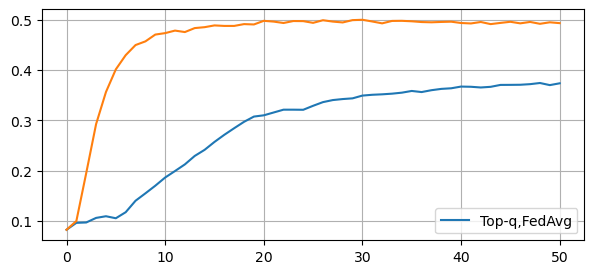

In [10]:
Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
start = time.time()
#-----------------------------------------------------
for k in range(num_global_iterations):
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, err = top_lambda_percent(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            Bits[i,k] = (462410*Lambda[i]/100)*b_j
            print('Bits:', Bits[i,k])
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
           
            print('max_model:', np.max(Quantized_diff_local_global_weight), 'min_model:', np.min(Quantized_diff_local_global_weight))
    
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Top-q,FedAvg'])
plt.grid(True, which='major')    
stop = time.time()
print('time:', stop - start)
            
            
            

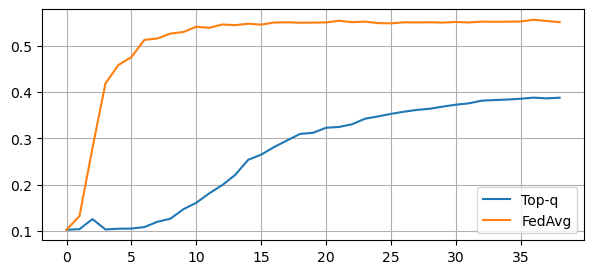

In [10]:
acc_q_temp = np.array(global_acc_list)
acc_fed_temp = np.array(global_acc_list_FedAvg)

acc_q = acc_q_temp[0:39]
acc_fed = acc_fed_temp[0:39]

#K=40, L=5, b=4, q = 0.04 %
plt.figure(figsize=(7, 3))
plt.plot(acc_q )    
plt.plot(acc_fed)
plt.legend(['Top-q', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            


In [14]:
Bits[:,6]

array([36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8,
       36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8,
       36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8,
       36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8,
       36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8, 36992.8,
       36992.8, 36992.8, 36992.8, 36992.8, 36992.8])

In [ ]:
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Top-q,FedAvg'])
plt.grid(True, which='major')    

In [6]:
acc_q = np.array(global_acc_list)
acc_fed = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'Top_q0.04_Noniid_K40_L5_b5_T50'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    #'A_bar': A_bar,
    #'B_bar': B_bar,
    'Bits' : Bits,#[:,0:39],
    #'percentage': percentage,
    #'I_M': I_M,
    #'B_tilde': B_tilde,
   # 'Lambda': Lambda,
    'acc_q' : acc_q,
    'acc_fed': acc_fed
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


Bits saved to C:/FedASi files\Top_q0.04_Noniid_K40_L5_b5_T50\Bits.npy
acc_q saved to C:/FedASi files\Top_q0.04_Noniid_K40_L5_b5_T50\acc_q.npy
acc_fed saved to C:/FedASi files\Top_q0.04_Noniid_K40_L5_b5_T50\acc_fed.npy


In [16]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the input data x with b bits.
    
    Parameters:
    x (numpy array): Input data to be quantized, can be negative
    b (int): Number of bits for quantization
    
    Returns:
    numpy array: Quantized data
    """
    x_max = np.max(np.abs(x))
    x_min = -x_max
    R = x_max - x_min
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / (L - 1)

    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [-x_max, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized

def adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j):
    """
    Quantize a vector based on a specified percentage of the largest absolute values,
    preserving the signs of the quantized elements.

    Parameters:
    main_vector (numpy array): Input data vector
    dim (int): Dimension of the vector
    lambda_j (float): Percentage of largest absolute values to be quantized
    b_j (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data vector with preserved signs
    """
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Calculate the number of elements to retain based on lambda_j percentage
    num_elements = len(main_vector)
    num_retain = int(np.ceil(lambda_j*100 * num_elements / 100))

    # Find the indices of the largest `num_retain` absolute values
    indices = np.argsort(-np.abs(main_vector))[:num_retain]

    # Create a temporary vector with the same shape as main_vector
    x_temp_before = np.copy(main_vector)
    
    # Set all elements not in the largest `num_retain` to zero
    x_temp_before[np.setdiff1d(np.arange(num_elements), indices)] = 0

    # Quantize the temporary vector with uniform quantization
    x_q_temp = uniform_quantization(x_temp_before, b_j)

    # Reconstruct the final quantized vector with the signs preserved
    x_q = np.copy(main_vector)
    x_q[indices] = x_q_temp[indices]

    # For elements that are not quantized, we set them to zero (or any other desired value)
    x_q[np.setdiff1d(np.arange(num_elements), indices)] = 0

    err = main_vector - x_q

    # Return the results
    return x_q, err

# Example usage
main_vector = 0.1*np.array([1, -2, 3, -4, 5, 0.1])
dim = len(main_vector)
lambda_j = 0.5  # Percentage of elements to retain
b_j = 3
x_quant, err = adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j)
print("Quantized vector:", x_quant)
print("Error:", np.max(np.abs(err)))


Quantized vector: [ 0.          0.          0.35714286 -0.35714286  0.5         0.        ]
Error: 0.2
